## Imports

In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Tuple

## Loading data

In [10]:
# if not os.path.exists('../data/precipitation_data.csv'):
#         download_precip_data()
# else:
#   ...
precip = pd.read_csv("../data/precipitation_data.csv", index_col=0)
precip

C:\Users\adamp\AppData\Local\Temp\ipykernel_48644\3095326748.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  precip = pd.read_csv("../data/precipitation_data.csv", index_col=0)


,station_code,station_name,year,month,day,24h_precipitation_mm,SMDB_status,precip_type,snow_cover_cm,PKSN_status,fresh_snow_cover_cm,HSS_status,snow_type_code,GATS_status,snow_cover_type_code,RPSN_status
0,249180020,WARSZOWICE,1991,1,2,5.5,NaN,W,0,8.0,0,8.0,NaN,8.0,NaN,8.0
1,249180020,WARSZOWICE,1991,1,3,3.5,NaN,W,0,8.0,0,8.0,NaN,8.0,NaN,8.0
2,249180020,WARSZOWICE,1991,1,4,1.9,NaN,W,0,8.0,0,8.0,NaN,8.0,NaN,8.0
3,249180020,WARSZOWICE,1991,1,7,3.3,NaN,W,0,8.0,0,8.0,NaN,8.0,NaN,8.0
4,249180020,WARSZOWICE,1991,1,10,0.0,NaN,W,0,8.0,0,8.0,NaN,8.0,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14122,254230020,SEJNY,2023,12,26,8.3,NaN,S,0,9.0,0,9.0,NaN,9.0,.,NaN
14123,254230020,SEJNY,2023,12,27,0.5,NaN,S,2,NaN,2,NaN,5.0,NaN,*,NaN
14124,254230020,SEJNY,2023,12,28,0.2,NaN,W,0,9.0,0,9.0,NaN,9.0,.,NaN
14125,254230020,SEJNY,2023,12,29,8.9,NaN,W,0,9.0,0,9.0,NaN,9.0,.,NaN


In [11]:
stations_gdf = gpd.read_file("../data/stations.shp", encoding="cp1250")
stations_gdf

,N,ID,name,river,lat,lon,altitude,geometry
0,1,250180590,RYBNIK-STODO?Y,Ruda,50.154444,18.483056,216,POINT (18.48306 50.15444)
1,2,254140010,DZIWNÓW,None,54.022222,14.731667,7,POINT (14.73167 54.02222)
2,3,250160530,ZIELENIEC,Bystrzyca Dusznicka,50.330000,16.394167,840,POINT (16.39417 50.33000)
3,4,250160630,MI?DZYGÓRZE,Wilczka,50.218333,16.773056,800,POINT (16.77306 50.21833)
4,5,250160650,MI?DZYLESIE,Nysa K?odzka,50.153333,16.670833,453,POINT (16.67083 50.15333)
...,...,...,...,...,...,...,...,...
636,637,250140020,SIENIAWKA,Nysa ?u?ycka,50.893889,14.835556,234,POINT (14.83556 50.89389)
637,638,250160920,PI?AWA GÓRNA,Pi?awa,50.689444,16.732500,295,POINT (16.73250 50.68944)
638,639,249180590,RUPTAWA,Olza,49.936667,18.589444,230,POINT (18.58944 49.93667)
639,640,250180760,STRZELCE OPOLSKIE,Ma?a Panew,50.517778,18.311111,229,POINT (18.31111 50.51778)


## Helpful functions from /src/visualizations/visualize_stations.py

In [12]:
def get_voivodeship_borders() -> gpd.GeoDataFrame:
    """Function to fetch and return voivodeship borders data as GeoDataFrame from a specified URL with spaces and dashes removed from voivodeship names.

    Returns:
        gpd.GeoDataFrame: GeoDataFrame containing voivodeship borders
    """
    geojson = gpd.read_file(
        "https://simplemaps.com/static/svg/country/pl/admin1/pl.json"
    )
    geojson["name"] = (
        geojson["name"]
        .apply(lambda x: x.replace(" ", ""))
        .apply(lambda x: x.replace("-", ""))
    )
    return geojson


def clip_to_voivodeship(
    gdf: gpd.GeoDataFrame, geojson: gpd.GeoDataFrame, voi: str
) -> Tuple[gpd.GeoSeries, gpd.GeoDataFrame]:
    """Function to clip GeoDataFrame to specific voivodeship borders

    Parameters:
        gdf (gpd.GeoDataFrame): GeoDataFrame containing stations data
        geojson (gpd.GeoDataFrame): GeoDataFrame containing voivodeship borders
        voi (str): Name of the voivodeship to clip the data to

    Returns:
        Tuple[gpd.GeoSeries, gpd.GeoDataFrame]: Tuple containing voivodeship polygon and clipped GeoDataFrame
    """
    voi_polygon = geojson[geojson["name"] == voi]["geometry"]
    voi_gdf = gdf[gdf.within(voi_polygon.geometry.iloc[0])]
    return voi_polygon, voi_gdf

## Filtering data to an only one voivodeship

In [13]:
vois = get_voivodeship_borders()
_, voi_gdf = clip_to_voivodeship(stations_gdf, vois, "Masovian")
voi_gdf

,N,ID,name,river,lat,lon,altitude,geometry
28,29,252190120,?YCHLIN,Bzura,52.242778,19.623056,97,POINT (19.62306 52.24278)
29,30,252200080,BORKOWO,Wkra,52.561944,20.660278,85,POINT (20.66028 52.56194)
30,31,252210050,PU?TUSK,Narew,52.727500,21.090278,95,POINT (21.09028 52.72750)
129,130,252210290,RYBIENKO,Bug,52.577778,21.429167,93,POINT (21.42917 52.57778)
166,167,253210210,MYSZYNIEC,Rozoga,53.384444,21.350278,120,POINT (21.35028 53.38444)
183,184,251200150,?AZISKA,Radomka,51.323889,20.925833,180,POINT (20.92583 51.32389)
184,185,252210240,WIELGOLAS,Wis?a,52.037222,21.723889,150,POINT (21.72389 52.03722)
206,207,351210488,KOZIENICE,Wis?a,51.564722,21.543611,123,POINT (21.54361 51.56472)
208,209,352190360,P?OCK,Wis?a,52.588333,19.725833,106,POINT (19.72583 52.58833)
209,210,352220385,SIEDLCE,Liwiec,52.181111,22.244722,152,POINT (22.24472 52.18111)


In [14]:
merged_gdf = precip.merge(voi_gdf, how="inner", left_on="station_code", right_on="ID")
merged_gdf

,station_code,station_name,year,month,day,24h_precipitation_mm,SMDB_status,precip_type,snow_cover_cm,PKSN_status,...,snow_cover_type_code,RPSN_status,N,ID,name,river,lat,lon,altitude,geometry
0,251200080,BIAŁOBRZEGI,1991,1,1,1.1,NaN,W,0,8.0,...,NaN,8.0,282,251200080,BIA?OBRZEGI,Pilica,51.657222,20.950833,116,POINT (20.95083 51.65722)
1,251200080,BIAŁOBRZEGI,1991,1,2,1.1,NaN,W,0,8.0,...,NaN,8.0,282,251200080,BIA?OBRZEGI,Pilica,51.657222,20.950833,116,POINT (20.95083 51.65722)
2,251200080,BIAŁOBRZEGI,1991,1,4,1.6,NaN,W,0,8.0,...,NaN,8.0,282,251200080,BIA?OBRZEGI,Pilica,51.657222,20.950833,116,POINT (20.95083 51.65722)
3,251200080,BIAŁOBRZEGI,1991,1,5,0.4,NaN,W,0,8.0,...,NaN,8.0,282,251200080,BIA?OBRZEGI,Pilica,51.657222,20.950833,116,POINT (20.95083 51.65722)
4,251200080,BIAŁOBRZEGI,1991,1,9,0.7,NaN,W,0,8.0,...,NaN,8.0,282,251200080,BIA?OBRZEGI,Pilica,51.657222,20.950833,116,POINT (20.95083 51.65722)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27644,252210240,WIELGOLAS,2023,12,24,7.8,NaN,W,2,NaN,...,*,NaN,185,252210240,WIELGOLAS,Wis?a,52.037222,21.723889,150,POINT (21.72389 52.03722)
27645,252210240,WIELGOLAS,2023,12,25,5.4,NaN,W,0,9.0,...,.,NaN,185,252210240,WIELGOLAS,Wis?a,52.037222,21.723889,150,POINT (21.72389 52.03722)
27646,252210240,WIELGOLAS,2023,12,26,4.8,NaN,W,0,9.0,...,.,NaN,185,252210240,WIELGOLAS,Wis?a,52.037222,21.723889,150,POINT (21.72389 52.03722)
27647,252210240,WIELGOLAS,2023,12,29,0.2,NaN,W,0,9.0,...,.,NaN,185,252210240,WIELGOLAS,Wis?a,52.037222,21.723889,150,POINT (21.72389 52.03722)


## Preparing data for the visualization

In [15]:
pivot_table = merged_gdf.pivot_table(
    index="year", columns="station_name", aggfunc="count"
)["24h_precipitation_mm"].fillna(0)

pivot_table_normalized = pivot_table.map(lambda x: int(min(x / 12, 12))).reset_index()

pivot_table_normalized_melted = pivot_table_normalized.melt(
    id_vars=["year"], value_name="no_months"
)
pivot_table_normalized_melted

,year,station_name,no_months
0,1991,BIAŁOBRZEGI,7
1,1992,BIAŁOBRZEGI,11
2,1993,BIAŁOBRZEGI,12
3,1994,BIAŁOBRZEGI,12
4,1995,BIAŁOBRZEGI,12
...,...,...,...
259,2019,ŻYCHLIN,11
260,2020,ŻYCHLIN,5
261,2021,ŻYCHLIN,0
262,2022,ŻYCHLIN,0


## The plot

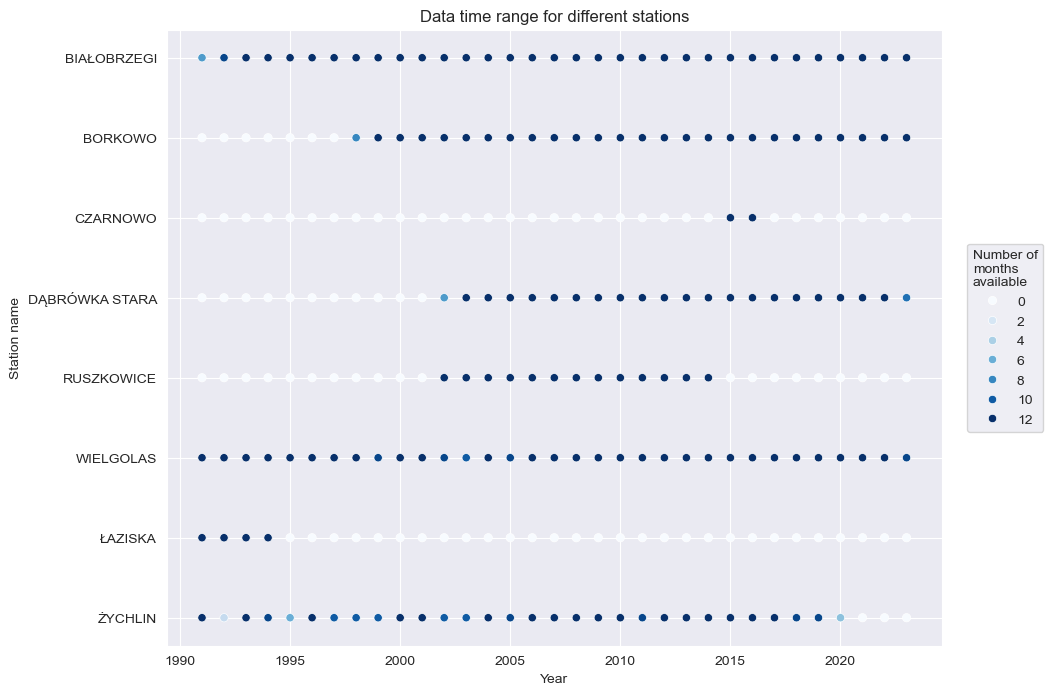

In [17]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.scatterplot(
    pivot_table_normalized_melted,
    x="year",
    y="station_name",
    hue="no_months",
    ax=ax,
    palette="Blues",
)
ax.set(
    title="Data time range for different stations", xlabel="Year", ylabel="Station name"
)
ax.legend(
    loc="center right",
    bbox_to_anchor=(1.14, 0.5),
    title="Number of\nmonths\navailable",
    alignment="center",
)

# plt.savefig(f"../results/Lubusz_data_availability.png")
plt.show()